In [1]:
from PIL import Image
from ultralytics.models.sam import SAM2Predictor
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import filters, img_as_ubyte

In [2]:
overrides = dict(task="segment", mode="predict", imgsz=1024, model="models/sam2_l.pt")
predictor = SAM2Predictor(overrides=overrides)

In [3]:
img_path = "data/obb_crops/4d372a841722af279bb16c74808a67d6e4a5986e_det0_cls0.png"
im = Image.open(img_path)
width, height = im.size
img_area = width * height
input_points = [[round(width/2) - round(width/8), round(height/2)], [round(width/2) + round(width/8), round(height/2)]]
results = predictor(img_path, points=input_points, labels=[1, 1], multimask_output=True)


Ultralytics 8.3.158  Python-3.12.10 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10239MiB)
image 1/1 E:\Jetbrains IDE Projects\Uni\BeeClassifier\data\obb_crops\4d372a841722af279bb16c74808a67d6e4a5986e_det0_cls0.png: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 875.7ms
Speed: 52.7ms preprocess, 875.7ms inference, 79.7ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to E:\Jetbrains IDE Projects\Uni\BeeClassifier\runs\segment\predict24


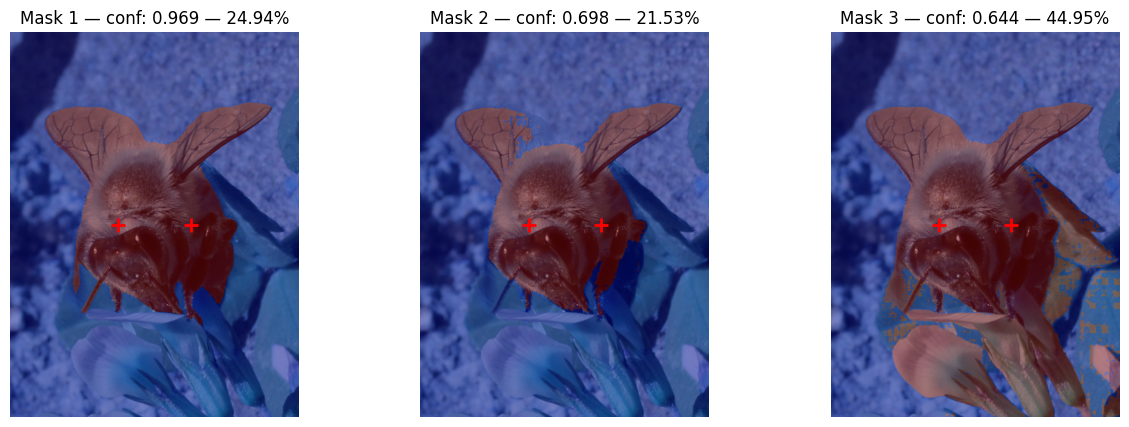

In [4]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Extract masks & confidences
masks = results[0].masks.data.cpu().numpy()
confidences = results[0].boxes.conf.cpu().numpy()

# Calculate coverage percentage for each mask
coverages = [(mask.sum() / img_area) * 100 for mask in masks]

# Sort by confidence descending
order = np.argsort(-confidences)
masks = masks[order]
confidences = confidences[order]
coverages = np.array(coverages)[order]

# Convert points for plotting
x_coords = [p[0] for p in input_points]
y_coords = [p[1] for p in input_points]

# Plot top 3
plt.figure(figsize=(15, 5))
for i in range(min(3, len(masks))):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.imshow(masks[i], alpha=0.5, cmap="jet")
    plt.scatter(
        x_coords, y_coords,
        color="red", marker="+", s=100, linewidths=2
    )
    plt.axis("off")
    plt.title(
        f"Mask {i+1} — conf: {confidences[i]:.3f} — {coverages[i]:.2f}%"
    )
plt.show()